In [1]:
##스타트업 파일

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


## EDA(Exploratory Data Analysis)

### Data 설명

* 배경: Austin Animal Shelter : Animal shelter 이지만 주로 개, 고양이 위주로 서비스를 제공 
* Austin, Texas

* 26729 rows * 10 features
* Case 건수 :2013년 2702건,2014년 1179건,2015년11481건, 2016년 1367건
* 추가적인 background 설명: 미국에서는 인식칩이 비싸기 때문에 애완용 가축중 인식칩이 안되어있는 가축이 많고 그에 따라 shelter에 들어오는 개체수중 이름이 없는 경우가 많음 

### Independant features 
* independant features = 8 , outcome feature =1 (Suboutcme feature =1 )
* Original Data features = AnimalID, Name, DateTime, OutcomeType, OutcomeSubtype, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, Color

* Animal ID: 고유 ID 
* Name : 이름있음, 없음으로 2개의 카테고리값으로 분류 
* DateTime: OutcomeType 이 시행된 날짜와 시간 (Austin Animal Shelter에서 확인) 
* Animal Type: Dog or Cat 2가지 카테고리
* SexuponOutcome: 5가지 카테고리(Intact Vs. Neutered / Male Vs. Female/ Unknown) 
* AgeuponOutcome: Day,Week, Month, Years 입력 1day~20years까지 다양 
* Breed: 고양이의 경우 , 개의 경우 입력된 Original Catecory 개수
* Color: 입력된 Original Catecory 개수


### Outcome Features
* OutcomeType: Shelter를 떠나는 개체의 결론 5가지 카테고리(Adoption, Transfer, Euthanasia, Return to Owner, Died) 
* OutcomeSubtype: Outcome에 대한 이유 (특이사항만 적혀있음, Nan 값이 많음) 

* nan 값 또는 unknown 값 확인 후 imputing 처리 

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.tail() 

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,NaN,2015-05-14 11:56,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 9:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [3]:
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A695206,Max,2015-08-11 0:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


### NAN 값 확인

In [4]:
train.isnull().any()
# Nan count 확인
for i in train.columns:
    print('Nan cnt of {} : {}'.format(i, format(train[i].isnull().sum())))
    
print('total rows cnt: ',train.size)

Nan cnt of AnimalID : 0
Nan cnt of Name : 7691
Nan cnt of DateTime : 0
Nan cnt of OutcomeType : 0
Nan cnt of OutcomeSubtype : 13612
Nan cnt of AnimalType : 0
Nan cnt of SexuponOutcome : 1
Nan cnt of AgeuponOutcome : 18
Nan cnt of Breed : 0
Nan cnt of Color : 0
total rows cnt:  267290


## Outcome : 5 Categories  

OutcomeType
Adoption           10769
Died                 197
Euthanasia          1555
Return_to_owner     4786
Transfer            9422
Name: AnimalID, dtype: int64

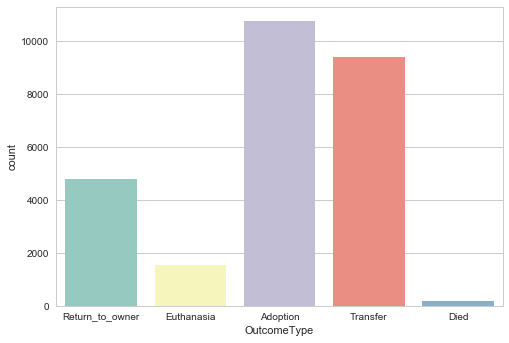

In [9]:
sns.countplot(train.OutcomeType, palette='Set3')
train.groupby("OutcomeType").count()['AnimalID']

### OutcomeSubtype: Outcome 의 근거 (Nan:13612건)

* Outcome에 큰영향을 미치나 Test set에는 없는 feature이고 Outcome이 나오는 시점에 발생 (feature 선택에서 탈락) 

In [10]:
# count of OutcomeSubtype
train.groupby(['OutcomeType', 'OutcomeSubtype']).count()

AnimalID  Name  DateTime  AnimalType  \
OutcomeType OutcomeSubtype                                              
Adoption    Barn                        1     0         1           1   
            Foster                   1800  1542      1800        1800   
            Offsite                   165   132       165         165   
Died        At Vet                      4     3         4           4   
            Enroute                     8     1         8           8   
            In Foster                  52    29        52          52   
            In Kennel                 114    35       114         114   
            In Surgery                  3     2         3           3   
Euthanasia  Aggressive                320   278       320         320   
            Behavior                   86    74        86          86   
            Court/Investigation         6     6         6           6   
            Medical                    66    38        66          66   
            Rabies Risk                74    43        74          74   
            Suffering                1002   301      1002        1002   
Transfer    Barn                        1     1         1           1   
            Partner                  7816  4436      7816        7816   
            SCRP                     1599    58      1599        1599   

                                 SexuponOutcome  AgeuponOutcome  Breed  Color  \
OutcomeType OutcomeSubtype                                                      
Adoption    Barn                              1               1      1      1   
            Foster                         1800            1800   1800   1800   
            Offsite                         165             165    165    165   
Died        At Vet                            4               4      4      4   
            Enroute                           8               8      8      8   
            In Foster                        52              52     52     52   
            In Kennel                       114             114    114    114   
            In Surgery                        3               3      3      3   
Euthanasia  Aggressive                      320             320    320    320   
            Behavior                         86              86     86     86   
            Court/Investigation               6               6      6      6   
            Medical                          66              66     66     66   
            Rabies Risk                      74              74     74     74   
            Suffering                      1002            1000   1002   1002   
Transfer    Barn                              1               1      1      1   
            Partner                        7816            7816   7816   7816   
            SCRP                           1599            1583   1599   1599   

                                 Date  Time  Weekday   Day  Month  Year  
OutcomeType OutcomeSubtype                                               
Adoption    Barn                    1     1        1     1      1     1  
            Foster               1800  1800     1800  1800   1800  1800  
            Offsite               165   165      165   165    165   165  
Died        At Vet                  4     4        4     4      4     4  
            Enroute                 8     8        8     8      8     8  
            In Foster              52    52       52    52     52    52  
            In Kennel             114   114      114   114    114   114  
            In Surgery              3     3        3     3      3     3  
Euthanasia  Aggressive            320   320      320   320    320   320  
            Behavior               86    86       86    86     86    86  
            Court/Investigation     6     6        6     6      6     6  
            Medical                66    66       66    66     66    66  
            Rabies Risk            74    74       74    74     74    

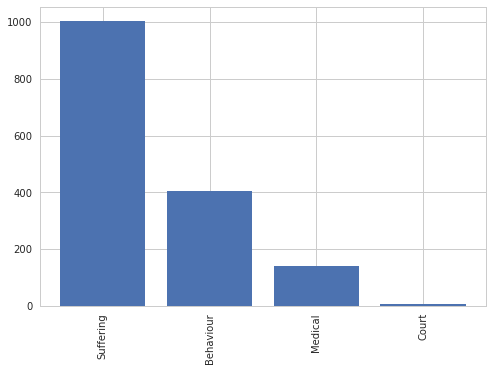

In [70]:
## 안락사의 경우 subtype 이유 
## 1. 고통, 지병
## 2. 공격적인 성향 또는 행동문제
## 3. 광견병 또는 전염병의 Medical 의 이유 
## 4. 위법, 법적인 문제 

euthanasia = train[train["OutcomeType"] == "Euthanasia"] 
subtype = euthanasia["OutcomeSubtype"].value_counts()

suffering = subtype["Suffering"]
behaviour = subtype["Aggressive"] +subtype["Behavior"]
medical = subtype["Rabies Risk"] + subtype["Medical"] 
Court = subtype["Court/Investigation"] ## 법적문제


subtype_list = [suffering,behaviour,medical,Court]
list_names = ["Suffering","Behaviour","Medical","Court"]
ind2 = np.arange(len(subtype_list))

plt.bar(ind2,subtype_list)
plt.xticks(ind2,list_names, rotation = 90)
plt.show()

## Features Insight 분석

### DateTime : Outcome이 실행된 시간 (Feature 채택에서 탈락)

In [5]:
import datetime

def date(x):
    x = str(x)
    date = x.split(' ')[0]
    return date 

def time(x):
    x = str(x)
    x = x.split(' ')[1]
    time =x.split(':')[0]
    return time 


train['Date']=train['DateTime'].apply(date)
train['Time']=train['DateTime'].apply(time)   

In [6]:
import datetime

def year(x):
    x=str(x)
    year =int(x.split('-')[0])
    #day=int(x.split('-')[2])
    ## MON = 0, TUE = 1, WED = 2....
    return year

def month(x):
    x=str(x)
    month =int(x.split('-')[1])
    #day=int(x.split('-')[2])
    ## MON = 0, TUE = 1, WED = 2....
    return month
    
    
def day(x):
    x=str(x)
    #month =int(x.split('-')[1])
    day=int(x.split('-')[2])
    ## MON = 0, TUE = 1, WED = 2....
    return day

def weekday(x):
    x=str(x)
    dayString =["MON","TUE","WED","THU","FRI","SAT","SUN"]
    year =int(x.split('-')[0])
    month =int(x.split('-')[1])
    date=int(x.split('-')[2])
    ## MON = 0, TUE = 1, WED = 2....
    return dayString[datetime.date(year,month,date).weekday()]

train['Weekday']=train['Date'].apply(weekday)
train['Day']=train['Date'].apply(day)
train['Month']=train['Date'].apply(month)
train['Year']=train['Date'].apply(year)


Year
2013     2702
2014    11179
2015    11481
2016     1367
dtype: int64

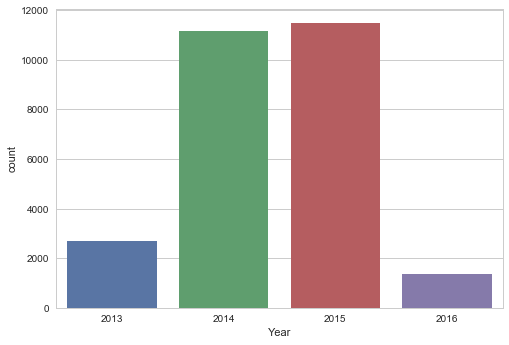

In [7]:
sns.countplot(x='Year',data=train)
x = train.groupby('Year').size()
x

Month
1     2334
2     1873
3     1498
4     1689
5     2094
6     2319
7     2506
8     2172
9     2004
10    2881
11    2668
12    2691
dtype: int64

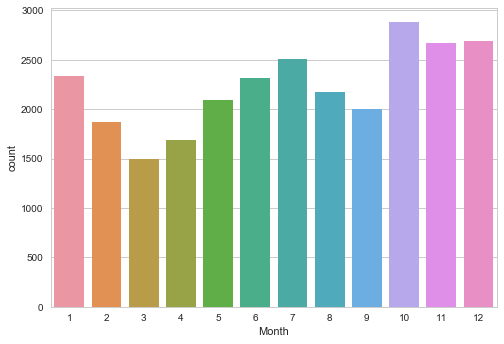

In [8]:
sns.countplot(x='Month',data=train)
train.groupby('Month').size()

## Animal Type : 2 Categories

### Cats = 11134, Dogs = 15595, Total = 26728

In [12]:
train.groupby("AnimalType").count() 
## Cats = 11134, Dogs = 15595

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,Time,Weekday,Day,Month,Year
AnimalType,,,,,,,,,,,,,,,
Cat,11134,6115,11134,11134,7511,11134,11117,11134,11134,11134,11134,11134,11134,11134,11134
Dog,15595,12923,15595,15595,5606,15594,15594,15595,15595,15595,15595,15595,15595,15595,15595


AnimalType
Cat    11134
Dog    15595
dtype: int64

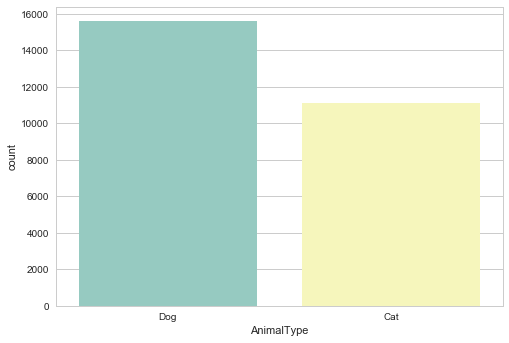

In [13]:
sns.countplot(train.AnimalType, palette='Set3')
train.groupby('AnimalType').size()


OutcomeType      AnimalType
Adoption         Cat           4272
                 Dog           6497
Died             Cat            147
                 Dog             50
Euthanasia       Cat            710
                 Dog            845
Return_to_owner  Cat            500
                 Dog           4286
Transfer         Cat           5505
                 Dog           3917
dtype: int64

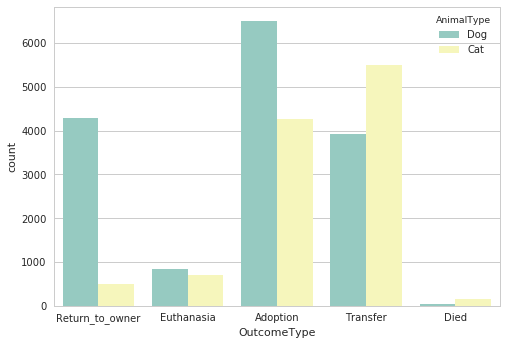

In [76]:
sns.countplot(data=train, x ='OutcomeType',hue='AnimalType',palette='Set3')
train.groupby(['OutcomeType','AnimalType']).size()
## Dog의 경우  Return to Owner, Adoption이 많으나 고양이의 경우 Trasfer가 많음 

## SexuponOutcome: 5 Categories

SexuponOutcome
Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
dtype: int64

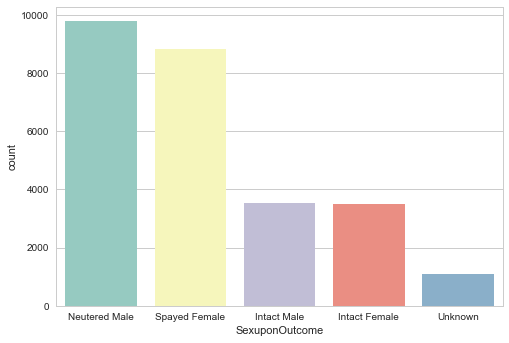

In [15]:
sns.countplot(train.SexuponOutcome, palette='Set3')
train.groupby('SexuponOutcome').size().sort_values(ascending = False)
## Unknown : 1093건 

SexuponOutcome  OutcomeType    
Intact Female   Adoption            203
                Died                 56
                Euthanasia          401
                Return_to_owner     301
                Transfer           2550
Intact Male     Adoption            158
                Died                 79
                Euthanasia          477
                Return_to_owner     477
                Transfer           2334
Neutered Male   Adoption           5222
                Died                 19
                Euthanasia          344
                Return_to_owner    2247
                Transfer           1947
Spayed Female   Adoption           5186
                Died                 18
                Euthanasia          232
                Return_to_owner    1748
                Transfer           1636
Unknown         Died                 25
                Euthanasia          101
                Return_to_owner      12
                Transfer            955
dtype: i

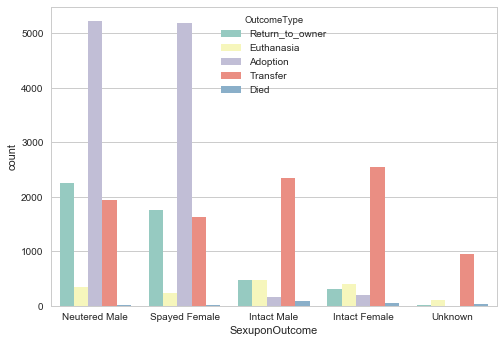

In [16]:
sns.countplot(x=train.SexuponOutcome,hue=train.OutcomeType, palette='Set3')
train.groupby(['SexuponOutcome','OutcomeType']).size()
## 중성화 되었을경우 Return to Owner, Adoption case가 많음 
## 중성화가 안된경우 transfer 높음, 안락사도 1.5배 이상
## Unknown 의 경우 transfer의 경우가 제일 높음 

In [17]:
def sex(x):
    x = str(x)
    if x.find("Male") >=0: return 'Male'
    if x.find("Female") >=0 : return 'Female'
    return 'Unknwon' ## Imputing: Unknown
def neutered(x):
    x = str(x)
    if x.find('Spayed')>=0: return 'Neutered'
    if x.find('Neutered')>=0: return 'Neutered'
    if x.find('Intact')>=0: return'Intact'
    return 'Unknwon' ## imputing: Unknown

In [18]:
train['Sex'] = train.SexuponOutcome.apply(sex)
train['Neutered'] = train.SexuponOutcome.apply(neutered)    

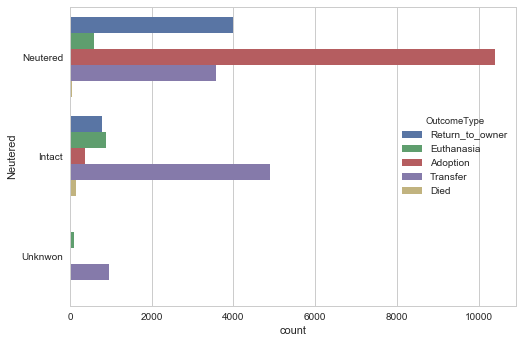

In [19]:
sns.countplot(data = train, y = 'Neutered', hue = 'OutcomeType') 
## 중성화 수술 하면 Adoption, Return to Owener의 경우가 늘어남
## 중성화가 안되거나 Unknown인경우 transfer가 상대적으로 높음 

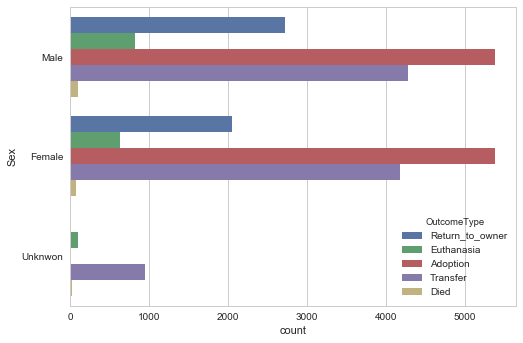

In [20]:
sns.countplot(data = train, y = 'Sex', hue = 'OutcomeType') ## 별다른 차이 없음

## Color: 366 Categories

In [21]:
color = train["Color"]
len(color.unique())

In [23]:
div_color = []
for i in color:
    i = i.split("/")[0]
    div_color.append(i)

In [24]:
def color1(x):
    if x.find("/") >= 1 : return x.split("/")[0]
    if x.find(" ") >= 1: return x.split(" ")[0]
    else: return x


In [25]:
train["Color1"] = train["Color"].apply(color1)


In [26]:
def color_maj(x):
    brown_color = ["Brown", "Apricot", "Buff", "Chocolate", 'Chocolate Point',
                   "Ruddy", "Liver" ,'Brown Brindle','Brown Tabby','Brown Merle','Liver','Liver Tick','Brown Merle', 'Brown Tiger']
    lig_brown_color = ["Fawn", "Gold",  "Tan", "Yellow",'Orange Tabby','Orange', 'Agouti']
    black_color = ["Black", "Flame",'Black Tabby','Black Smoke','Black Brindle','Black Tiger']
    white_color = ["White", "Cream", "Lynx",'Cream Tabby']
    lig_black_color = ["Gray", "Lilac", "Silver",'Seal','Seal Point','Gray Tabby','Silver Tabby']
    rare_color = ["Blue", "Tricolor", "Calico", "Sable", "Pink", "Torbie", "Tortie",'Tortie Point',
                  "Agouti",'Tricolor', 'Red','Yellow','Blue Tabby','Buff','Blue Smoke','Pink',
                  'Yellow Brindle','Red Tick','Sable','Apricot','Red Merle', 'Blue Merle',
                 'Lynx Point', 'Lilac', 'Lynx','Blue Tiger','Blue Cream','Calico Point','Blue Tick', 'Blue Point']
        
    if x in brown_color: return "Brown"
    if x in lig_brown_color: return "Light Brown"
    if x in black_color: return "Black"
    if x in lig_black_color: return "Light Black"
    if x in white_color: return "White"
    if x in rare_color: return "Rare Color"
    


In [27]:
train['Color2']=train["Color1"].apply(color_maj)

train.Color2.unique()
## 총 6그룹으로 분류 

array(['Brown', 'White', 'Rare Color', 'Light Brown', 'Black',
       'Light Black'], dtype=object)

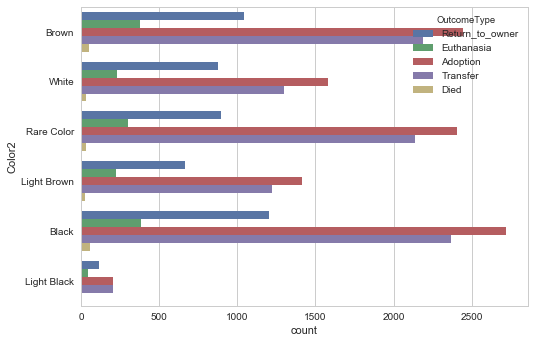

In [28]:
sns.countplot(data=train, y='Color2',hue='OutcomeType')
## light black 의 카테고리 값 빼고 대부분 같은 특성을 보임 

## Age : 1day~ 20 years까지 다양 

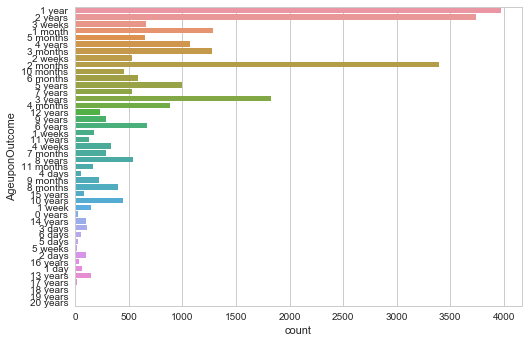

In [29]:
sns.countplot(y = train.AgeuponOutcome) ## Original Data
## Nan값:18 건, Unknown: 0건 , 0 years: 22 건 

In [66]:
np.where(train['AgeuponOutcome']=='0 years')

(array([  280,  1734,  2474,  3195,  4051,  4209,  4398,  5256,  5443,
         7609,  9144, 10699, 12982, 13108, 15399, 15605, 16745, 18404,
        19203, 19626, 21891, 22911], dtype=int64),)

In [31]:
def Ageimputer(x):
    x = str(x)
    if x.lower() == 'nan': return '3 years' #int(np.mean(train['AgeInYears']))
    else: return x
    

In [67]:
train['AgeuponOutcome'] = train['AgeuponOutcome'].apply(Ageimputer)


In [33]:
def calc_age_in_years(x):
    x = str(x)
    age = int(x.split()[0])
    if x.find('year') > -1: 
        if age ==0: return 0.1 ## 0 years 로 표시 되어있는 동물들 22 마리 0.1로 변환 
        else: return age
    elif x.find('month')> -1:
        if age <=6: return 0.5 ## 6개월미만 float 0.5로 변환 
        else:
            return 1
    elif x.find('week')> -1: return 0.1#float('{:.1f}'.format(int(x.split()[0])/52)) ## float 0.1 로 변형 
    elif x.find('day')> -1: return 0.1 #float('{:.1f}'.format(int(x.split()[0])/52)) ## float 0.1 로 변형
    else: return np.mean(x)


In [34]:
train['AgeInYears'] = train['AgeuponOutcome'].apply(calc_age_in_years)

In [35]:
np.where(train['AgeInYears']==0.0) ## 0살 샘플 확인 필요 0 years ## 대부분 Transfer, some are Euthanasia or Died

(array([], dtype=int64),)

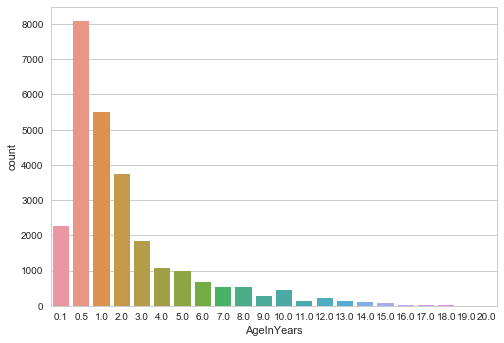

In [36]:
sns.countplot(train.AgeInYears)

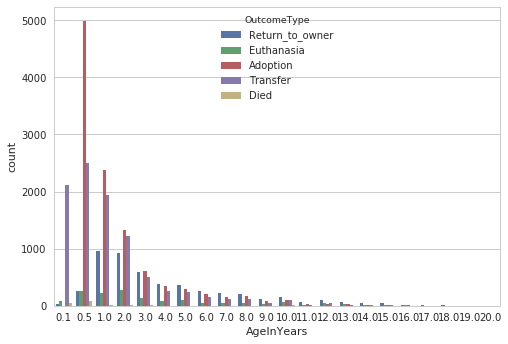

In [81]:
sns.countplot(data=train, x='AgeInYears',hue='OutcomeType')## 결과에 따른 나이
## 한달미만의 개체는 Transfer가 높으며 6개월미만의 개체들은 Adoption비율이 높다 
## 1년이상의 개체는 Return to Owner의 비율이 1년미만의 개체보다 상대적으로 높다. 
#train.groupby(['AgeInYears','OutcomeType']).size()

In [38]:
def calc_age_category(x):
    
    if x < 0.5: return 'cubs'
    elif x < 1: return 'young'
    elif x < 5: return 'young adult'
    elif x < 10: return 'adult'
    return 'old'
train['AgeCategory'] = train.AgeInYears.apply(calc_age_category)


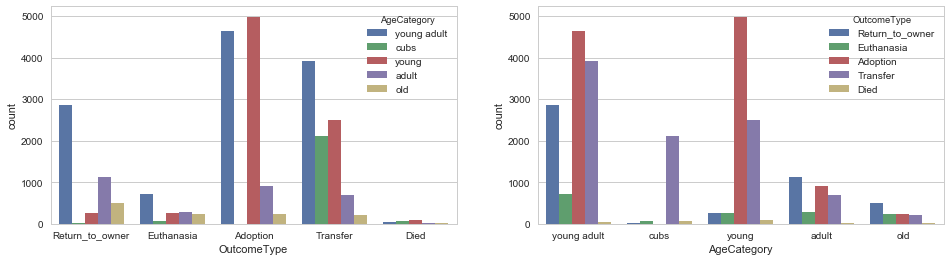

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)## 결과에 따른 나이
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)## 나이에 따른 결과 


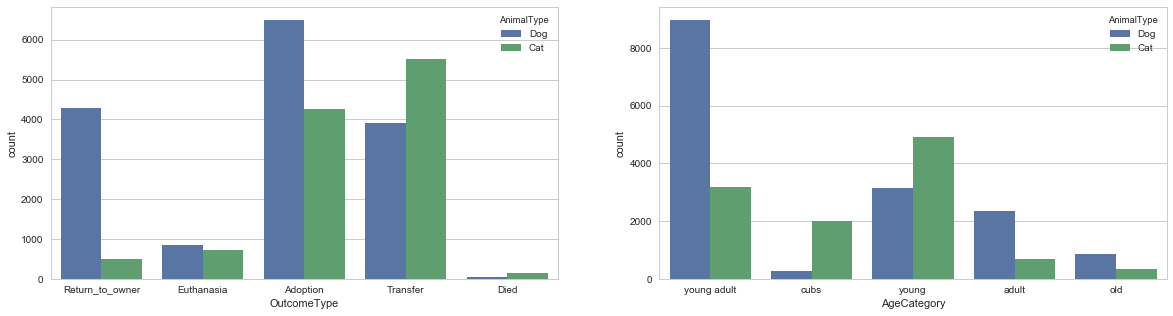

In [40]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=train, x ='OutcomeType',hue='AnimalType',ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='AnimalType', ax=ax2)## 나이에 따른 Animal Type  


## Breed Feature Values Category 분류 

### Dog Breeds: 1320 Categories

In [41]:
## Animal Type = Dog 인것중에 개 Breed 로 나눠 인덱싱, 총 1320 Categories 
feature = 'Breed'

feature_values_dog = train.loc[train['AnimalType'] == 'Dog',feature]
group = train.groupby([feature_values_dog])
group.size().sort_values(ascending = False)

Breed
Pit Bull Mix                              1906
Chihuahua Shorthair Mix                   1766
Labrador Retriever Mix                    1363
German Shepherd Mix                        575
Australian Cattle Dog Mix                  367
Dachshund Mix                              318
Boxer Mix                                  245
Miniature Poodle Mix                       233
Border Collie Mix                          229
Australian Shepherd Mix                    163
Rat Terrier Mix                            157
Catahoula Mix                              157
Jack Russell Terrier Mix                   146
Yorkshire Terrier Mix                      143
Chihuahua Longhair Mix                     142
Siberian Husky Mix                         138
Miniature Schnauzer Mix                    136
Beagle Mix                                 124
Rottweiler Mix                             113
American Bulldog Mix                       109
Cairn Terrier Mix                          102
Shih Tz

### Cat Breeds: 60 Categories

In [42]:
## 고양이 종류 총 60여가지, 크게 나누면 훨씬 쉬움
## 약 80프로 이상의 고양이가 5가지 이내의 카테고리 분류로 들어감 
feature_values_cat = train.loc[train['AnimalType'] == 'Cat',feature]
feature_values_cat
group = train.groupby([feature_values_cat])
group.size().sort_values(ascending = False) 

Breed
Domestic Shorthair Mix                     8810
Domestic Medium Hair Mix                    839
Domestic Longhair Mix                       520
Siamese Mix                                 389
Domestic Shorthair                          143
Snowshoe Mix                                 75
Manx Mix                                     44
Maine Coon Mix                               44
Domestic Medium Hair                         42
Russian Blue Mix                             33
Siamese                                      24
Domestic Longhair                            23
Himalayan Mix                                15
Persian Mix                                  12
Ragdoll Mix                                  11
Siamese/Domestic Shorthair                   11
American Shorthair Mix                        9
Angora Mix                                    7
Japanese Bobtail Mix                          6
Bombay Mix                                    5
Balinese Mix                      

## Dog's type: 10 categories (위키피디아 참조)

In [82]:
## Dog's type 총 10 category

## 목양견, 양치기견
Herding = ['Bearded Collie', 'Beauceron', 'Belgian Malinois','Malinois','Anatol','Anatol Shepherd',
       'Belgian Sheepdog', 'Belgian Tervuren', 'Bergamasco','Kelpie/Pit','Kelpie/Finnish',
       'Berger Picard', 'Shetland Sheepdog', 'Border Collie','Border Collie/Greyhound', 'Briard',
       'Pyrenean Shepherd', 'Puli', 'Polish Lowland Sheepdog','Border','Collie/Rottweiler',
       'Cardigan Welsh Corgi','Cardigan', 'Pembroke Welsh Corgi','Welsh','Corgi/Brittany','Border Collie/Rottweiler',
       'Old English Sheepdog', 'Collie', 'Norwegian Buhund','Pointer/Collie Smooth','Pointer/Collie',
       'Miniature American Shepherd', 'Entlebucher Mountain Dog','Belgian Malinois','Dutch','Dutch Shepherd'
       'Finnish Lapphund', 'Gefrman Shepherd', 'Icelandic Sheepdog','Catahoula/Pit',
       'Spanish Water Dog', 'Australian Shepherd Mix', 'Australian Shepherd','Bouvier des Flandres',
       'Queensland Heeler','Heeler', 'Swedish Vallhund','Swedish Vallhund Mix','Vallhund', 'Australian Cattle Dog',
        'Black Mouth Cur','Mouth','Catahoula', 'Anatolian Shepherd Dog',
        'Collie','Sheepdog','Corgi','Mountain','Cattle','Water Dog']
Australian_Shepherd = ['Australian Shepherd Mix','Australian Shepherd','Australian Shepherd/Anatol Shepherd']

## 사냥견
Hound = ['Greyhound','Basset', 'Hound','Saluki','Rhodesian Ridgeback','Redbone Coonhound','Treeing','Treeing Walker Coonhound',
         'Treeing Walker Coonhound Mix','Beagle/Pointer','Beagle/Staffordshire','Portuguese Podengo Pequeno','Podengo Pequeno Mix',
         'Podengo','Plott','Norwegian Elkhound','Pharaoh Hound','Petit Basset Griffon Vend_en','Pug/Beagle','Beagle/Pug',
         'Afghan Hound','Otterhound','Whippet','Borzoi','English Foxhound','Irish Wolfhound','Wolfhound','Basenji','Basset Hound',
         'Boxer/Beagle','Beagle','Beagle/Treeing','Harrier','Harrier/Catahoula','Sloughi','Ibizan Hound','American Foxhound','Foxhound',
         'Rhod Ridgeback','Rhod ','Ridgeback','Rhod/Ridgeback','Black and Tan Coonhound','Beagle/Chihuahua','Pbgv','Boxer/Harrier',
         'American English Coonhound','Coonhound','Bloodhound','Bluetick Coonhound','Scottish Deerhound','Plott Hound',
         "Cirneco dell'Etna",'Pit Bull/Dogue De Bordeaux','Carolina','De','Bordeaux','Basenji/Chihuahua']

## 실내견,가정견,애완견 Companian dogs
Non_Sporting = ['Finnish','French Bulldog','Keeshond','Dalmatian','Dalmatian/Boxer','Sharpei','Chinese Sharpei','Chinese Sharpei Mix','Coton de Tulear',
 'Lhasa Apso','Lhasa', 'Apso','Norwegian Lundehund','L_wchen','Xoloitzcuintli','Schipperke','Schipperke/Chihuahua','American Bulldog','Bulldog/Pointer',
 'English Bulldog','Bichon Fris','Bichon Frise Mix','Bichon','Bulldog','Standard Poodle','Eskimo','Tibetan Spaniel','Bulldog/Chihuahua',
 'Chinese Shar Pei','Miniature Poodle','Shiba Inu','Mexican Hairless Mix','Crested']
## 스포츠견, 활동적, 야외활동
Sporting = ['Greyhound/Dalmatian','Irish Red and White Setter','Irish Setter','Setter/Pit','Sussex Spaniel','Nova Scotia Duck Tolling Retriever','Irish Water Spaniel',
 'Labrador Retriever','Retriever/Whippet','Labrador','Lagotto Romagnolo','Vizsla','Vizsla Mix','Vizsla/Boxer','Vizsla/Staffordshire',
 'Vizsla/Rhod Ridgeback', 'Vizsla/Catahoula','Weimaraner','Pointer','Pointer/Catahoula','Catahoula/Pointer','Dachshund/Harrier','Canario',
 'Welsh Springer Spaniel','Springer', 'Spaniel','WireDachshund/Chihuahuahaired Pointing Griffon','Dachshund/Catahoula','Dachshund/German','Landseer','Jindo',
 'Wirehaired Vizsla','Spinone Italiano','Spinone','Spinone Italiano Mix','Gordon Setter','Brittany','Golden','Golden Retriever','Boykin','Boykin Span Mix','Boykin Spaniel','American Water Spaniel','American Eskimo Dog',
 'English Cocker Spaniel','English Setter','English Setter Mix','Curly-Coated Retriever','Cocker Spaniel','Cocker','English Springer Spaniel','Field Spaniel','Shiba','Inu/Dachshund',
 'Clumber Spaniel','Flat Coat','Flat','Flat Coated Retriever','Retriever','Chesapeake Bay Retriever','Chesa','Chow Chow','Chow','Bay','German Shorthaired Pointer',
 'German Wirehaired Pointer','Cocker Spaniel/Dachshund','Spaniel/Dachshund','Dachshund','Dachshund/Pit','Dachshund/Beagle',
 'Beagle/Dachshund','Dachshund/Chihuahua','Dachshund/Catahoula','Dachshund/Whippet','Wirehaired']
## 테리어견종 - 사냥견중 작은 품종( 주로 오소리, 새등을 잡는 품종으로 개량됨)
Terrier = ['Skye Terrier','Cesky Terrier','Norfolk Terrier','Dandie Dinmont Terrier','Border Terrier','Scottish Terrier','Terrier/Dachshund',
 'Norwich Terrier','Parson Russell Terrier','Miniature Schnauzer','Rat Terrier','Sealyham Terrier','Russell Terrier','Terrier/Boxer','Tibetan Terrier',
 'Bedlington Terrier','Smooth Fox Terrier','Bull Terrier (Miniature)','Staffordshire','Staffordshire/Labrador Retriever',
 'Staffordshire/French Bulldog','Staffordshire/English Bulldog','Staffordshire/Boxer','Staffordshire/Beagle','Glen of Imaal Terrier','Imaal','Wire Fox Terrier','Boston Terrier',
 'Bull Terrier','Highland','West Highland White Terrier','Irish Terrier','Welsh Terrier','Airedale Terrier','Staffordshire Bull Terrier',
 'Kerry Blue Terrier','Cairn Terrier','American Hairless Terrier','Lakeland Terrier','American Staffordshire Terrier','Australian Terrier',
 'Manchester Terrier','Soft-Coated Wheaten Terrier','Miniature Bull Terrier', 'Cairn Terrier/Chihuahua Shorthair','Terrier/Chihuahua','Cairn Terrier',
 'Jack Russell Terrier Mix','Rat Terrier','Cairn','Russell','Rat','Terrier/Border','Norwich Terrier/Pug','Terrier/Pug','Terr','Feist']
## 토이견 
Toy = ['Toy','Poodle/Maltese','Toy Poodle/Maltese','Brussels Griffon','Pomeranian','Silky Terrier','American Eskimo Dog (Toy)',
       'Toy Fox Terrier','Affenpinscher','Shih Tzu','Shih', 'Tzu','Whippet/Chihuahua Shorthair','Whippet/Chihuahua','Bruss Griffon Mix','Bruss',
        'Pug','Pug/Chihuahua','Yorkshire Terrier','Toy Poodle','Miniature Pinscher','Japanese Chin','Chinese Crested Dog','Maltese','Pekingese',
         'Italian Greyhound','English Toy Spaniel','Papillon','Chihuahua','Havanese','Cavalier King Charles Spaniel','Cavalier','Bull/Chihuahua',
         'Miniature','Poodle','Yorkshire', 'Terrier','Norfolk','West Highland/Chihuahua Shorthair','Highland/Chihuahua',
       'Papillon/Chihuahua Shorthair','Papillon/Chihuahua','Maltese/Yorkshire']
## 비지니스 활동견
Working = ['Giant Schnauzer','Australian Kelpie','Kelpie','Alaskan Malamute','Alaskan', 'Malamute',
       'Greater Swiss Mountain Dog', 'Komondor', 'Kuvasz','Blue Lacy/Beagle','Lacy/Beagle',
           'Blue Lacy','Lacy','Blue Lacy/Pit Bull','Lacy/Pit','Lacy/Collie','Boxer/Staffordshire',
       'Tibetan Mastiff', 'Great Pyrenees','Great Pyrenees Mix','Pyrenees', 'Leonberger',
       'Pinscher', 'Standard Schnauzer','Great Pyrenees/Anatol Shepherd','Pyrenees/Anatol',
       'Mastiff', 'Bullmastiff', 'Canaan','Schnauzer','Cane Corso','Corso',
        'St.','St. Bernard','St. Bernard Rough Coat Mix', 'Boxer', 'Samoyed',
       'Doberman Pinscher', 'Boerboel', 'Bernese Mountain Dog', 'Chinook','Akita Mix','Akita',
       'Siberian Husky','Husky','Siberian Husky/German Shepherd','Siberian','Husky/German', 'Newfoundland', 'Neapolitan Mastiff',
       'Doberman Pinsch','Doberman', 'Pinsch', 'Portuguese Water Dog', 'Black Russian Terrier',
       'Great Dane','Great','Dane','Dane/Staffordshire','Great Dane/Staffordshire']
Unknown = ['Unknown','Unknown Mix','Nan','nan']
## 맹견, 투사견 또는 fierce
Fierce = ['Pit','Pit Bull','Pit Bull Mix','American Pit Bull Terrier Mix','American Pit Bull Terrier','Dogo Argentino','Pit Bull/Pit Bull',
            'Pit Bull Terrier','Labrador Retriever/Pit Bull','Pit Bull/Rottweiler','Pit Bull/Chinese Sharpei','Bull/Chinese',
            'Bull/Rottweiler','Rottweiler Mix','Rottweiler','Boxer/Pit Bull','Pit Bull/Boxer','Pit Bull/St. Bernard Smooth Coat',
            'Dogo','Argentino','Dogo Argentino Mix','Dogo Argentino/Chinese Sharpei','kita/Pit Bull','Akita/Pit','Pit Bull/Weimaraner',
            'American Pit Bull Terrier/Chinese Sharpei','Pit Bull/Mastiff','Mastiff/Pit Bull','Pit Bull/Catahoula','Canaan Dog/Pit Bull',
         'American Pit Bull Terrier/Catahoula']
## Guard 견 
German_Shepherd = ['German Shepherd Mix','German Shepherd','German Shepherd/Akita','Shepherd/Australian',
                   'German Shepherd/Rottweiler','German Shepherd/Pit Bull','German Shepherd/Catahoula','Rottweiler/German Shepherd',
                   'German','Shepherd/Rottweiler','German Shepherd/Collie Rough','Beagle/German','German Shepherd/Boxer',
                   'Beagle/German Shepherd','Boxer/German Shepherd','German Shepherd/Mastiff','German Shepherd/Collie Smooth']

## Cat's Type: 9 Categories (위키피디아 참조)

In [44]:
## Cat's Type 9종류 분류 ( 위키피디아 기준)

## 미국토종 고양이 (미국인들 선호, 대부분의 고양이가 여기에 포함), 쥐잡이용 고양이, 활동성 큼, 건강함 , 애교많음 , 질투많음
## Domestic _short 의 경우 압도적으로 개체수가 많음 (9천건 이상), Mediumhair, Longhair는 각각 천마리 미만
Domestic_Short= ['American Shorthair Mix','Domestic Shorthair Mix',
            'Domestic Shorthair','Domestic Shorthair/Domestic Medium Hair']
Domestic_Medium = ['Domestic Medium Hair Mix','Domestic Medium Hair' ]
Domestic_Long = [ 'Domestic Longhair Mix','Domestic Longhair','Domestic Longhair/Rex']

## 브리티쉬 고양이 ( 미국 토종고양이의 조상)
British = ['British Shorthair Mix','Domestic Shorthair/British Shorthair','British Shorthair']
## 시암고양이, 우아함, 특이한 색, 흰색& 회백색 얼굴 , 질투많음, 관심 보살핌 필요
Siamese = ['Siamese Mix','Siamese','Siamese/Domestic Shorthair','Domestic Medium Hair/Siamese',
           'Domestic Shorthair/Siamese' ,'Siamese/Japanese Bobtail']
#스노우 슈: 여왕의 고양이, 온순하고 영리. 혼자 방치되는 것을 싫어함
Snowshoe =['Snowshoe','Snowshoe Mix','Snowshoe/Ragdoll']
##특이품종이지만 개채수 20마리 이상
Russian_Blue = ['Russian Blue Mix','Russian Blue','Domestic Longhair/Russian Blue']
Persian = ['Persian Mix','Persian','Domestic Longhair/Persian']
Manx = ['Manx Mix','Manx','Manx/Domestic Longhair','Manx/Domestic Shorthair','Domestic Shorthair/Manx']
Maine_Coon = ['Maine Coon Mix','Maine Coon']
## 특이 품종 20 마리 미만
Exotic = ['Abyssinian Mix','Himalayan Mix','Himalayan','Bengal Mix','Bengal','Ragdoll Mix','Angora Mix','Japanese Bobtail Mix',
          'Bombay Mix','Balinese Mix','Tonkinese Mix','Pixiebob Shorthair Mix','Cymric Mix','Turkish Van Mix',
          'Sphynx','Exotic Shorthair Mix','Javanese Mix','Cornish Rex Mix','Ragdoll','Burmese','Devon Rex Mix',
          'Ocicat Mix','Devon Rex','Norwegian Forest Cat Mix','Munchkin Longhair Mix','Havana Brown Mix']



In [45]:

def BreedGroups(x):
      
    x =str(x)
    if x: ## 개 3그룹으로 선분류 
        if x in Unknown:
            return 'Companion'  ##array([ 4967, 23667]) - Dogs, return to owner & Names exsist
        elif x in Fierce:
            return 'Fierce'
        elif x in German_Shepherd:
            return 'Working'
        elif x in Australian_Shepherd:
            return 'Herding'
        
        ## 고양이 그룹 분류: 9 종류 
        elif x in Domestic_Short: ## Domestic Shorthair 의 개체수가 압도적으로 많음 9천건 이상
            return 'Domestic'
        elif x in Domestic_Medium:
            return 'Domestic'
        elif x in Domestic_Long:
            return 'Domestic'
            
        elif x in British:
            return 'Exotic'
        elif x in Siamese:
            return 'Exotic'
        elif x in Snowshoe:
            return 'Exotic'
        elif x in Russian_Blue:
            return 'Exotic'
        elif x in Persian:
            return 'Exotic'
        elif x in Manx:
            return 'Exotic'
        elif x in Maine_Coon:
            return 'Exotic'
        elif x in Exotic:
            return 'Exotic'
        
## 선분류 그룹에 속하지 않는 그룹: 개 7 종류 (목적 분류 세분화 )       
        else: 
            x = x.split()
            for i in x: 
                if i in Herding:
                    return 'Herding'
                elif i in Hound:
                    return 'Hunting'
                elif i in Non_Sporting:
                    return 'Companion'
                elif i in Sporting:
                    return 'Sporting'
                elif i in Terrier:
                    return 'Hunting'
                elif i in Toy:
                    return 'Toy'
                elif i in Working:
                    return 'Working'
                
        return 'Sporting'

In [46]:
train['BreedGroup'] = train['Breed'].apply(BreedGroups)

## Dog: 7 Categories, Cat: 2 Catgegories , Total: 9 Categories 

BreedGroup
Companion      401
Domestic     10388
Exotic         746
Fierce        2367
Herding       1904
Hunting       1576
Sporting      3459
Toy           4097
Working       1791
dtype: int64

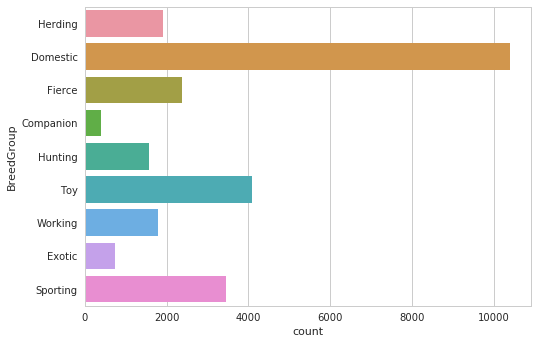

In [83]:
sns.countplot(data =train, y='BreedGroup')
train.groupby('BreedGroup').size()

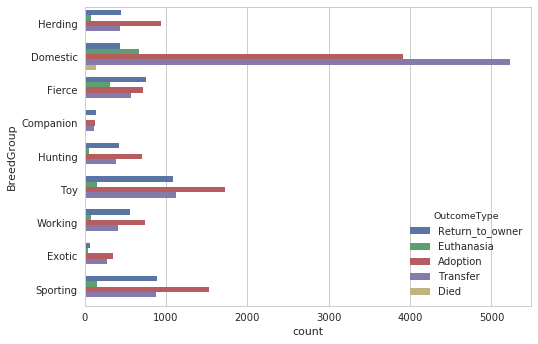

In [85]:
sns.countplot(data=train, y='BreedGroup',hue ="OutcomeType")
#train.groupby(['BreedGroup','OutcomeType']).size()

## Mix 견종 Vs. 순종 : 2 Categories 

In [51]:
def Mix(x): ## Mix 인지 아닌지 구분 (개, 고양이 모두 포함 )
    x =str(x)
    if x.lower == 'nan'or '': return 'Unknown'
    if x.find('Mix')>-1:return 'Mix'
    elif x.find('/')>-1:return 'Mix'
    else:
        return 'Pure Breed'

In [52]:
train['Mix'] = train.Breed.apply(Mix)
#train['Mix']
#sns.countplot(data=train, x ='Mix')
train.groupby(['Mix']).size()

Mix
Mix           25338
Pure Breed     1391
dtype: int64

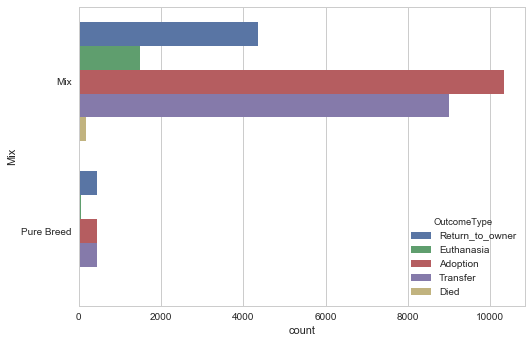

In [53]:
sns.countplot(data=train, y='Mix',hue ="OutcomeType") 
## Mix의 Sample수가 훨씬많고 결과에 따른 분포가 높으나 pure breed의 경우 안락사율이 낮고 Return to owener, Adoption,Transfer의 경우가 거의 비슷하게 나옴

## Name : 이름 존재 Vs. 없음으로 구분 (Nan 값:7691 건)

In [54]:
def Name(x):
    x= str(x)
    if x == 'Nan': return 'No'
    elif x =='nan': return 'No'
    elif x.lower() =='unknown': return 'No'
    else: return 'Yes'

In [55]:
train['NameExsist'] = train['Name'].apply(Name)
train['Name'].isnull().sum()

7691

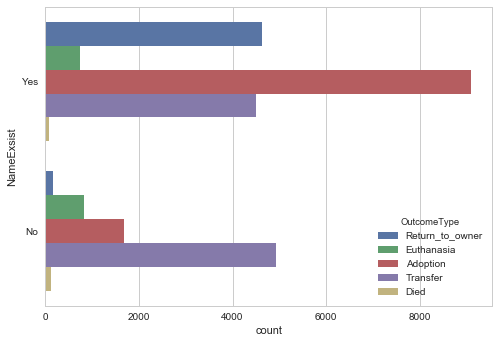

In [56]:
sns.countplot(data=train, y='NameExsist',hue ="OutcomeType") 
## 이름이 있는 경우 Return to Owner, Adoption의 경우가 훨씬 높음